## Scenario 1: Build a causal model when we have data and domain knowledge
Let's assume that our knowledge about dyspnoea is limited to:smoking is related to lung cancer, smoking is related to bronchitis, and if you have lung or bronchitus we may need an xray examination.

[bnlearn] >bayes DAG created.


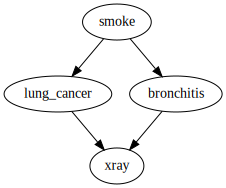

In [1]:
import graphviz as gr
import bnlearn as bn
import utils
import pandas as pd

df = pd.read_csv('dyspnoea.csv')
df.head()

edges = [('smoke', 'lung_cancer'),
('smoke', 'bronchitis'),
('lung_cancer', 'xray'),
('bronchitis', 'xray')]

# Create the DAG from the edges
DAG = bn.make_DAG(edges)
g = utils.plot_from_edges(edges)
g

In [2]:
DAG = bn.parameter_learning.fit(DAG, df, methodtype='bayes')

[bnlearn] >Removing columns from dataframe to make consistent with DAG [['tuberculosis_area' 'tuberculosis' 'dyspnea']]
[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >CPD of smoke:
+----------+----------+
| smoke(0) | 0.490182 |
+----------+----------+
| smoke(1) | 0.509818 |
+----------+----------+
[bnlearn] >CPD of lung_cancer:
+----------------+---------------------+---------------------+
| smoke          | smoke(0)            | smoke(1)            |
+----------------+---------------------+---------------------+
| lung_cancer(0) | 0.16765578635014836 | 0.09629101283880172 |
+----------------+---------------------+---------------------+
| lung_cancer(1) | 0.8323442136498517  | 0.9037089871611983  |
+----------------+---------------------+---------------------+
[bnlearn] >CPD of bronchitis:
+---------------+--------------------+--------------------+
| smoke         | smoke(0)           | smoke(1)           |
+---------------+--------------------+---------

In [3]:
# Print the CPDs
bn.print_CPD(DAG)

[bnlearn] >Data is stored in [query.df]
+----+---------+----------+
|    |   smoke |        p |
+====+=========+==========+
|  0 |       0 | 0.490182 |
+----+---------+----------+
|  1 |       1 | 0.509818 |
+----+---------+----------+
CPD of smoke:
+----------+----------+
| smoke(0) | 0.490182 |
+----------+----------+
| smoke(1) | 0.509818 |
+----------+----------+
[bnlearn] >Data is stored in [query.df]
+----+---------------+---------+----------+
|    |   lung_cancer |   smoke |        p |
+====+===============+=========+==========+
|  0 |             0 |       0 | 0.167656 |
+----+---------------+---------+----------+
|  1 |             0 |       1 | 0.096291 |
+----+---------------+---------+----------+
|  2 |             1 |       0 | 0.832344 |
+----+---------------+---------+----------+
|  3 |             1 |       1 | 0.903709 |
+----+---------------+---------+----------+
CPD of lung_cancer:
+----------------+---------------------+---------------------+
| smoke          | smok

{'smoke':    smoke         p
 0      0  0.490182
 1      1  0.509818,
 'lung_cancer':    lung_cancer  smoke         p
 0            0      0  0.167656
 1            0      1  0.096291
 2            1      0  0.832344
 3            1      1  0.903709,
 'bronchitis':    bronchitis  smoke         p
 0           0      0  0.587908
 1           0      1  0.332739
 2           1      0  0.412092
 3           1      1  0.667261,
 'xray':    xray  bronchitis  lung_cancer         p
 0     0           0            0  0.711052
 1     0           0            1  0.116686
 2     0           1            0  0.683983
 3     0           1            1  0.118573
 4     1           0            0  0.288948
 5     1           0            1  0.883314
 6     1           1            0  0.316017
 7     1           1            1  0.881427}

**What is the probability of lung-cancer, given that we know that patient does smoke $P(Lung-Cancer | smoke)$?**

In [4]:
q1 = bn.inference.fit(DAG, variables=['lung_cancer'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+---------------+----------+
|    |   lung_cancer |        p |
+====+===============+==========+
|  0 |             0 | 0.096291 |
+----+---------------+----------+
|  1 |             1 | 0.903709 |
+----+---------------+----------+


**What is the probability of bronchitis, given that we know patient does smoke $P(bronchitis | smoke)$?**

In [5]:
q2 = bn.inference.fit(DAG, variables=['bronchitis'], evidence={'smoke':1})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+--------------+----------+
|    |   bronchitis |        p |
+====+==============+==========+
|  0 |            0 | 0.332739 |
+----+--------------+----------+
|  1 |            1 | 0.667261 |
+----+--------------+----------+


**What is the probability of lung-cancer, given that we know that patient does smoke and also has bronchitis $P(lung-cancer | bronchitis, smoke)$?**

In [6]:
q3 = bn.inference.fit(DAG, variables=['lung_cancer'], evidence={'smoke':1, 'bronchitis':1})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+---------------+----------+
|    |   lung_cancer |        p |
+====+===============+==========+
|  0 |             0 | 0.096291 |
+----+---------------+----------+
|  1 |             1 | 0.903709 |
+----+---------------+----------+


**What is the probability of lung-cancer or bronchitis, given that we know that patient
does smoke but did not had xray?**

In [7]:
q4 = bn.inference.fit(DAG, variables=['lung_cancer','bronchitis'], evidence={'smoke':1, 'xray':0})

[bnlearn] >Variable Elimination..
[bnlearn] >Data is stored in [query.df]
+----+---------------+--------------+----------+
|    |   lung_cancer |   bronchitis |        p |
+====+===============+==============+==========+
|  0 |             0 |            0 | 0.131447 |
+----+---------------+--------------+----------+
|  1 |             0 |            1 | 0.253563 |
+----+---------------+--------------+----------+
|  2 |             1 |            0 | 0.202447 |
+----+---------------+--------------+----------+
|  3 |             1 |            1 | 0.412544 |
+----+---------------+--------------+----------+


## Scenario 2: Build a causal model when we have data, but no domain knowledge!

In [8]:
from pgmpy.estimators import PC, HillClimbSearch, MmhcEstimator
from pgmpy.estimators import K2Score
import bnlearn as bn
import utils
import graphviz as gr
import pandas as pd

In [9]:
df = pd.read_csv("dyspnoea.csv")

  0%|          | 0/5 [00:00<?, ?it/s]

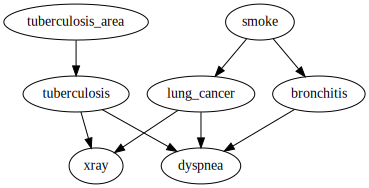

In [10]:
est = PC(data = df)
estimated_model = est.estimate(variant="stable", max_cond_vars=5, ci_test = "chi_square", return_type = "dag", significance_level = 0.01)
utils.plot_from_model_pgmpy(estimated_model.edges())